# 연구 목표

>오늘날 AI를 활용한 다양한 서비스가 우리 주위에서 익숙하고 자연스럽게 사용되고 있다. 음악 서비스에서는 사용자의 선호도에 따라 음악을 추천해주고, 금융 서비스에서는 은행원 대신 대출 서비스를 AI가 심사를 진행한다. 이처럼 사람 대신 의사결정을 진행해주는 AI에 대해, 사람들은 AI은 기계이므로 객관적이고 공정하게 결과를 제시한다고 생각하기 때문에, AI가 도출한 결과에 의문 대신 높은 신뢰를 하는 경향이 많다.<br>
> <br>
> 2016년에 발표된 'Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings'라는 논문은 AI도 학습에 사용된 데이터에 따라 객관적이지 않을 수 있음을 보여주었다. 사람들이 가지고 있는 편견이 AI가 학습하는 워드 임베딩 속 벡터들에 고스란히 반영되어 있었다는 것을 보여 주었기 때문이다.<br>
> <br>
> 이에, 본 연구에는 워드 임베딩 벡터들 간에는 의미적인 유사도 거리를 정량적으로 측정하는 Word Embedding Association Test (WEAT)과, 영화의 시놉시스 데이터를 활용하여, 21개의 영화 장르에 따른 일반 영화와 예술 영화에 대한 편향성을 측성하고, 어떤 영화 장르가 일반 영화와 예술 영화에 가까운지 확인하는 실험을 진행한다.

In [146]:
!pip install matplotlib-venn

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [149]:
!pip install --upgrade pip

     |████████████████████████████████| 1.7 MB 22.6 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.3.3
    Uninstalling pip-20.3.3:
      Successfully uninstalled pip-20.3.3


In [165]:
import os
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

from matplotlib_venn import venn2, venn2_circles
from numpy import dot
from numpy.linalg import norm
from konlpy.tag import Okt
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Word2Vec기반 워드 임베딩 벡터 생성

> 본 1장에서는 WEAT에 활용할 워드 임베딩을 생성하는 과정을 기술한다.<br>
> <br>
> WEAT에 활용할 워드 임베딩은 Word2Vec를 채택했다.<br>
> Word2Vec는 단어 벡터간 단어의 '의미'의 유사도를 계산하고 이를 수치화하여 표현할 수 있기에 자연어 편향성 측정 문제에 적합하다고 생각했다.<br>
> <br>
> Word2Vec 기반 워드 임베딩 생성을 위해 영화의 시놉시스 데이터(16.9 Mbyte)를 사용한다.<br>
> 시놉시스 데이터 중, 단어의 의미를 명확하게 표기하는 '체언' 중 '명사'만을 추출한다.<br>
> 관계언, 수식언, 용언 등 다른 품사는 단어의 의미를 명확하게 구분하는데 노이즈의 역할을 하므로 제거한다.<br>
> <br>
> 추출한 '명사' 데이터를 활용하여 Word2Vec 기반 워드 임베딩을 생성한다.

## 1.1 Data load

> Word2Vec 기반 워드 임베딩 생성을 위한 영화들의 시놉시스 데이터를 메모리에 적재 후 정보를 확인한다.<br>
> 영화들의 시놉시스 데이터는 2001년부터 2019년 8월까지 제작된 영화의 시놉시스를 국문으로 기록한 정보이다.<br>
> <br>
> 국문 영화 시놉시스 데이터는 아래 링크에서 확인할 수 있다.<br>
> [synopsis.zip](https://d3s0tskafalll9.cloudfront.net/media/documents/synopsis.zip)

In [7]:
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(10):
        print(i,': ',file.readline(), end='')

0 :  사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
1 :   젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
2 :   어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
3 :   자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
4 :   자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
5 :   너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
6 :   그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
7 :   이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
8 :   "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
9 :   영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.


> 영화들의 시놉시스 데이터. 이하, <code>synopsis</code> 데이터의 일부 정보를 출력한 결과는 위와 같다.

## 1.2 '명사' 단어만 추출

> WEAT에 활용할 word2Vec를 생성하기 위해, <code>konlpy</code> 패키지를 활용하여 <code>synopsis</code> 데이터에서 '명사' 데이터만 추출 후 <code>tokenized</code> 변수에 저장한다.<br>

In [8]:
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:
                res.append(w[0])
        tokenized.append(res)

> '명사' 단어 추출 작업에 계산 비용이 크므로 재사용할 수 있도록 추출된 단어를 <code>.txt</code> 파일로 저장한다. 

In [14]:
with open('./Data/lecture6/tokenized.txt', "wb") as f:
    pickle.dump(tokenized, f)

> '명사' 단어만 추출한 <code>tokenized</code>의 내용을 문장 원본과 비교하여 확인한다.

In [31]:
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(3):
        print('문장 원본 : ',file.readline(), end='')
        print('명사만 추출 :',tokenized[i])
        print('\n')
        
print(f"추출된 명사 : {len(tokenized)} 개 ")

문장 원본 :  사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
명사만 추출 : ['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분']


문장 원본 :   젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
명사만 추출 : ['시절', '상처', '아버지', '박인환', '분', '고모', '신신애', '분', '살']


문장 원본 :   어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
명사만 추출 : ['겨울', '그', '지방', '방송국', '라디오', '은수', '이영애', '분', '를']


추출된 명사 : 71156 개 


> 문장 원본과 비교했을 때, 품사가 '명사'인 단어만 추출되었음을 확인할 수 있다.

## 1.3 Make Word2Vec Embedding Vector

<code>tokenized</code>을 활용하여 Word2Vec 기반 임베딩 벡터를 생성한다.

In [32]:
word2vec_model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)

> 생성된 임베딩 벡터 모델의 성능을 테스트하는 작업을 진행한다.<br>
> <br>
> '영화'라는 단어를 입력했을때, '작품', '다큐멘터리',' 드라마', '코미디' 순으로 단어간 유사도를 출력했다.<br>
> '예술'이라는 단어를 입력했을때, '주제', '예술가', '대중', 시적' 순으로 단어간 유사도를 출력했다.<br>
> <br>
> 위 결과를 바탕으로 일반 영화는 다큐멘터리, 드라마, 코미디 관련 영화 장르가 유사성이 높을것이란 가설을 세울 수 있을것이다.<br>
> 예술 영화는 드라마, 철학 관련 영화 장르가 유사성이 높을것이라는 가설을 세울 수 있을것이다.

In [37]:
word2vec_model.wv.most_similar(positive=['영화'])

[('작품', 0.889788806438446),
 ('다큐멘터리', 0.8484927415847778),
 ('드라마', 0.8241448998451233),
 ('코미디', 0.8184667825698853),
 ('영화로', 0.8016467094421387),
 ('주제', 0.8010066747665405),
 ('감동', 0.7968703508377075),
 ('형식', 0.7904599905014038),
 ('실화', 0.7843252420425415),
 ('소재', 0.7813414931297302)]

In [38]:
word2vec_model.wv.most_similar(positive=['예술'])

[('주제', 0.9322843551635742),
 ('예술가', 0.9317293763160706),
 ('대중', 0.9140779972076416),
 ('시적', 0.9060763120651245),
 ('영화로', 0.9060647487640381),
 ('해석', 0.9020172953605652),
 ('영감', 0.9017684459686279),
 ('드라마', 0.9005115628242493),
 ('시각', 0.8975170254707336),
 ('철학', 0.8931575417518616)]

# 2. WEAT(Word Embedding Association Test)

> <code>synopsis</code> 데이터의 편향성을 관측하기 위해 WEAT 기법을 활용하고자 한다.<br>
> WEAT의 Target은 '일반영화' , '예술 영화' 2개이고, Attribute는 영화 장르인 21개이다.<br>
> <br>
> Target과 Attirubute를 대표할 단어를 선정하기위해 TF-IDF을 지표로 사용한다.<br>
> Target과 Attirubute의 각 대표 단어는 명사이며, 상위 5개 단어만 출력한다.<br>

## 2.0 Utility Function

> 각 데이터에서 명사만 추출할 수 있도록 편의성 함수를 사전에 구현한다.

In [40]:
# 명사 단어(토큰)을 추출하는 함수
def get_Noun_Token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

> 추출된 데이터를 재사용할 수 있도록 저장, 불러오는 기능 함수를 구현한다.

In [41]:
# 토큰 모음집을 저장하는 함수
def save_token(file_name, data):
    with open('./Data/lecture6/'+file_name, "wb") as f:
        pickle.dump(data, f)


# 토큰 모음집을 불러오는 함수
def load_token(file_name):
    with open('./Data/lecture6/'+file_name, "rb") as f:
        tokenizer = pickle.load(data, f)
        
    return tokenizer

## 2.1 WEAT Target

> WEAT의 Target 데이터는 <code>일반 영화</code>, <code>예술 영화</code> 2가지 이다.

### 2.1.1 WEAT Target에서 명사 단어 추출

> 아래의 각 데이터에서 명사 단어만을 추출 후, 재 작업시 계산비용 절약을 위해 결과를 <code>.txt</code> 파일로 저장한다.<br>
> <br>
> synopsis_art.txt : 예술영화<br>
> synopsis_gen.txt : 일반영화<br>

In [42]:
art = get_Noun_Token('synopsis_art.txt')
gen = get_Noun_Token('synopsis_gen.txt')

save_token('art_token.txt', art)
save_token('gen_token.txt', gen)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


### 2.1.2 Target TF-IDF 생성 및 출력

> <code>art</code>와 <code>gen</code>을 활용하여 TF-IDF를 생성한다.

In [46]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

> WEAT의 Target를 표현할 대표 단어 5개를 출력하는 기능함수를 구현한다.

In [80]:
def print_tfidf_word(data):
    for i in range(20):
        print(vectorizer.get_feature_names()[data[i][0]], ":", round(data[i][1],2))

> <code>art</code>와 <code>gen</code>의 TF-IDF 값을 내림차순으로 정렬했을 때, 상위 5개까지 대표 단어와 값(.2f까지)을 표기하여 출력한다.

In [81]:
m1 = X[0].tocoo()
m2 = X[1].tocoo()

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)
w2.sort(key=lambda x: x[1], reverse=True)

print('예술영화를 대표하는 단어들:')
print(print_tfidf_word(w1))

print('\n일반영화를 대표하는 단어들:')
print(print_tfidf_word(w2))

예술영화를 대표하는 단어들:
그녀 : 0.3
자신 : 0.29
시작 : 0.29
위해 : 0.26
사랑 : 0.25
사람 : 0.23
영화 : 0.16
친구 : 0.15
남자 : 0.13
가족 : 0.11
이야기 : 0.11
마을 : 0.1
사건 : 0.1
마음 : 0.1
세상 : 0.1
아버지 : 0.1
아이 : 0.09
엄마 : 0.09
모든 : 0.09
여자 : 0.09
None

일반영화를 대표하는 단어들:
자신 : 0.3
그녀 : 0.29
영화제 : 0.29
위해 : 0.24
사람 : 0.21
시작 : 0.21
국제 : 0.2
영화 : 0.18
친구 : 0.16
사랑 : 0.16
남자 : 0.15
이야기 : 0.13
대한 : 0.1
서울 : 0.1
여자 : 0.1
사건 : 0.1
남편 : 0.09
아이 : 0.09
가족 : 0.09
아버지 : 0.09
None


### 2.1.3 Target TF-IDF의 중복 제거

> WEAT의 Target의 대표 단어 선정의 지표로 TF-IDF을 사용했다.<br>
> Target의 대표 단어를 TF-IDF가 높은 순으로 출력하였을 때, '일반 영화'와 '예술 영화' 각 축에 중복된 단어가 다수 있음을 확인할 수 있다.<br>
> 연구 목표는 Target의 각 축이 대조되도록 대표하는 단어를 구성하는것이므로, 서로 중복되지 않게 단어 셋을 구성해야 한다.<br>
> 이에, Target의 상위 50개의 단어들 중 중복되는 단어를 제외하고 상위 5개의 단어를 추출하는 작업을 진행한다.

In [77]:
n = 5

w1_, w2_ = [], []
for i in range(50):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

target_art, target_gen = [], []
for i in range(50):
    if (w1_[i] not in w2_) and (w1_[i] in word2vec_model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

for i in range(50):
    if (w2_[i] not in w1_) and (w2_[i] in word2vec_model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [79]:
print('일반 영화 대표 단어 : ', target_gen)
print('예술 영화 대표 단어 : ', target_art)

일반 영화 대표 단어 :  ['국제', '서울', '단편', '작품', '생각']
예술 영화 대표 단어 :  ['점점', '여행', '인생', '모두', '순간']


> Target의 각 축에서 중복되는 단어를 제거했을 때 각 축의 대표 단어는 아래와 같다.<br>
> <br>
> 일반 영화 : <code>국제</code>, <code>서울</code>, <code>단편</code>, <code>작품</code>, <code>생각</code><br>
> 예술 영화 : <code>점점</code>, <code>여행</code>, <code>인생</code>, <code>모두</code>, <code>순간</code><br>

## 2.2 WEAT Attirubute

> WEAT의 Attirubute 데이터는 <code>SF</code>, <code>가족</code>, <code>공연</code>, <code>공포(호러)</code>, <code>다큐멘터리</code>, <code>드라마</code>, <code>멜로로맨스</code>, <code>뮤지컬</code>, <code>미스터리</code>, <code>범죄</code>, <code>사극</code>, <code>서부극(웨스턴)</code>, <code>성인물(에로)</code>, <code>스릴러</code>, <code>애니메이션</code>, <code>액션</code>, <code>어드벤처</code>, <code>전쟁</code>, <code>코미디</code>, <code>판타지</code> 21가지 이다.

### 2.2.1 WEAT Attirubute에서 명사 단어 추출

> 아래의 각 데이터에서 명사 단어만을 추출 후, 재 작업시 계산비용 절약을 위해 결과를 .txt 파일로 저장한다.
>
> 1. synopsis_SF.txt : SF 영화<br>
> 2. synopsis_family.txt : 가족 영화<br>
> 3. synopsis_show.txt : 공연 영화<br>
> 4. synopsis_horror.txt : 공포(호러) 영화<br>
> 5. synopsis_etc.txt : 기타 영화<br>
> 6. synopsis_documentary.txt : 다큐멘터리 영화<br>
> 7. synopsis_drama.txt : 다큐멘터리 영화<br>
> 8. synopsis_romance.txt : 멜로로맨스 영화<br>
> 9. synopsis_musical.txt : 뮤지컬 영화<br>
> 10. synopsis_mystery.txt : 미스터리 영화<br>
> 11. synopsis_crime.txt : 범죄 영화<br>
> 12. synopsis_historical.txt : 사극 영화<br>
> 13. synopsis_western.txt : 서부극(웨스턴) 영화<br>
> 14. synopsis_adult.txt : 성인물(에로) 영화<br>
> 15. synopsis_thriller.txt : 스릴러 영화<br>
> 16. synopsis_animation.txt : 애니메이션 영화<br>
> 17. synopsis_action.txt : 액션 영화<br>
> 18. synopsis_adventure.txt : 어드벤처 영화<br>
> 19. synopsis_war.txt : 전쟁 영화<br>
> 20. synopsis_comedy.txt : 코미디 영화<br>
> 21. synopsis_fantasy.txt : 판타지 영화<br>

In [45]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

genre = []
for file_name in genre_txt:
    genre.append(get_Noun_Token(file_name))
    
save_token('genre_token.txt', art)

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


### 2.2.2 Attirubute TF-IDF 생성 및 출력

> Attirubute의 값이 저장된 <code>genre</code>을 활용하여 TF-IDF를 생성한다.

In [117]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

> <code>genre</code>의 TF-IDF 값을 내림차순으로 정렬했을 때, 각 축의 상위 5개까지 출력한다.

In [118]:
m = [X[i].tocoo() for i in range(X.shape[0])]
w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)

    
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 5):
        if vectorizer.get_feature_names()[w[i][j][0]] in word2vec_model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], round(w[i][j][1], 2), end=', ')
        j += 1
    attributes.append(attr)
    print('\n','--'*30)

SF: 위해 0.26, 자신 0.26, 지구 0.24, 시작 0.23, 사람 0.19, 
 ------------------------------------------------------------
가족: 엄마 0.25, 아빠 0.23, 가족 0.2, 영화제 0.2, 자신 0.19, 
 ------------------------------------------------------------
공연: 오페라 0.27, 사랑 0.26, 토스카 0.21, 실황 0.2, 올레 0.17, 
 ------------------------------------------------------------
공포(호러): 시작 0.26, 위해 0.24, 사람 0.24, 자신 0.23, 친구 0.22, 
 ------------------------------------------------------------
기타: 영화제 0.51, 국제 0.4, 서울 0.36, 단편 0.31, 영화 0.15, 
 ------------------------------------------------------------
다큐멘터리: 영화제 0.33, 영화 0.28, 다큐 0.23, 국제 0.23, 다큐멘터리 0.22, 
 ------------------------------------------------------------
드라마: 자신 0.29, 영화제 0.29, 그녀 0.28, 사람 0.2, 사랑 0.2, 
 ------------------------------------------------------------
멜로로맨스: 그녀 0.47, 사랑 0.31, 자신 0.25, 시작 0.21, 남편 0.21, 
 ------------------------------------------------------------
뮤지컬: 뮤지컬 0.26, 사랑 0.2, 에스메랄다 0.19, 그녀 0.18, 음악 0.17, 
 -----------------------------------

# 3. WEAT기반 편향성 측정결과

> 본 3장에서는 2장에서 추출한 WEAT Target, Attirubute의 대표 단어를 활용하여 각 축과의 편향성을 WEAT score으로 측정한다.<br>
> WEAT score은 Cos(코싸인)의 유사도로 측정하며, 양수가 클수록 실험군(A)에 가깝다고 할 수 있고, 음수가 클수록 대조군(B)에 가깝다고 할 수 있다.<br>
> 모든 Target, Attirubute의 편향성 최종 결과는 heatmap으로 시각화하여 표현한다.

## 3.1 WEAT Score Function

> WEAT socre는 두 벡터의 유사도를 측정하기 위해 cosine similarity를 이용하며 이를 코드로 구현한 결과는 아래와 같다.<br>
> <br>
> cos(θ)=1: 두 벡터의 방향이 똑같을 때 <br>
> cos(\theta)=0cos(θ)=0: 두 벡터가 직교할 때<br>
> cos(\theta)=-1cos(θ)=−1: 두 벡터의 방향이 반대일 때<br>

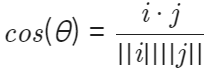

In [ ]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

> 실험군과 비교군과의 편향성을 측정하기 위해 s(w,A,B)가 사용되며,target에 있는 단어가 두 attribute 셋 A, B에 속한 단어들과의 유사도의 평균(mean)값이 얼마나 차이 나는지를 측정한다.<br>
> 절댓값이 클수록 A-B 개념축에 대해 편향성이 높다고 할 수 있다.

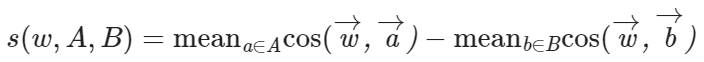

In [107]:
def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B

> 위 수식을 활용하여 작성된 최종 WEAT score는 아래 수식과 같이 정의할 수 있다.

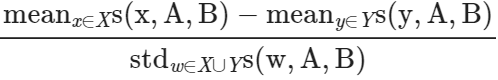

In [ ]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

> 위 수식을 활용하여 WEAT Target과 Attirubute의 Score를 추출한뒤 행렬 변수 <code>matrix</code>에 저장한다.<br>
> 그리고 <code>matrix</code>의 WEAT Score 점수에 따라 Target에 편향된 장르 데이터를 추출한다.<br>
> <br>
> WEAT Score 0.1 이상 일때 -> 예술 영화에 편향되었다.<br>
> WEAT Score -0.1 이하 일때 -> 일반 영화에 편향되었다.<br>
> WEAT Score 0.1 미만, -0.1 초과 일때 -> 어떤 Target에도 편향되지 않았다.

In [127]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

X = np.array([word2vec_model.wv[word] for word in target_art])
Y = np.array([word2vec_model.wv[word] for word in target_gen])

art_biase = list()
gen_biase = list()
null_biase = list()

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([word2vec_model.wv[word] for word in attributes[i]])
        B = np.array([word2vec_model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)  
        if matrix[i][j] >= 0.1:
            art_biase += [genre_name[i]]
            gen_biase += [genre_name[j]]
        elif matrix[i][j] < 0.1 and matrix[i][j] > -0.1:
            art_biase += [genre_name[i]]
            gen_biase += [genre_name[j]]
        elif matrix[i][j] <= -0.1:
            null_biase = [genre_name[j]]

# 4. 연구 결과

> 위 3장에서 분류 과정을 통해 2가지 Target과 21가지 Attirubute에서 편향된 영화 장르를 벤 다이어그램으로 시각화 하여 표현하면 아래 그림과 같다.<br>
> <br>
> [벤 다이어그램 참고 사이트](https://towardsdatascience.com/how-to-create-and-customize-venn-diagrams-in-python-263555527305)

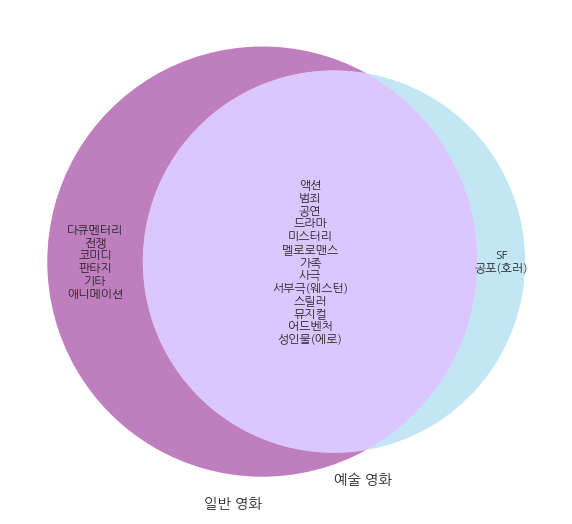

In [183]:
art_movire_biase = set(gen_biase)
gen_movire_biase = set(art_biase) 

plt.figure(figsize = (10, 10))
v = venn2(subsets=(art_movire_biase, gen_movire_biase), set_labels=('일반 영화', '예술 영화'),set_colors=('purple', 'skyblue'),alpha = 0.5) 
v.get_label_by_id('10').set_text('\n'.join(map(str,art_movire_biase - gen_movire_biase)))
v.get_label_by_id('11').set_text('\n'.join(map(str,art_movire_biase & gen_movire_biase)))
v.get_label_by_id('01').set_text('\n'.join(map(str,gen_movire_biase - art_movire_biase)))

plt.show()

> <code>다큐멘터리</code>, <code>전쟁</code>, <code>코미디</code>, <code>판타지</code>, <code>기타</code>, <code>애니메이션</code> 장르는 일반 영화(WEAT Score <= -0.1) 편향된 모습을 보여주었다.<br>
> <code>SF</code>, <code>공포(호러)</code> 장르는 예술 영화(WEAT Score >= 0.1) 편향된 모습을 보여주었다.<br>
> <code>액션</code>, <code>범죄</code>, <code>공연</code>, <code>드라마</code>, <code>미스터리</code>, <code>멜로로맨스</code>, <code>가족</code>, <code>사극</code>, <code>서부극(웨스턴)</code>, <code>스릴러</code>, <code>뮤지컬</code>, <code>어드벤처</code>, <code>성인물(에로)</code>는 편향되지 않는 모습을 보여주었다.

> 벤 다이어그램에서 표현하지 못한 WEAT score의 상세한 값을 출력한 결과는 아래와 같다.

In [110]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i],"-", genre_name[j],": ",matrix[i][j])
    print('--'*30)

SF - 가족 :  1.7296892
SF - 공연 :  1.4652212
SF - 공포(호러) :  -1.0948788
SF - 기타 :  1.6577326
SF - 다큐멘터리 :  1.6368878
SF - 드라마 :  1.7590516
SF - 멜로로맨스 :  -0.26238805
SF - 뮤지컬 :  1.4076309
SF - 미스터리 :  -0.056996804
SF - 범죄 :  0.50432676
SF - 사극 :  1.1535724
SF - 서부극(웨스턴) :  1.3644098
SF - 성인물(에로) :  0.7121802
SF - 스릴러 :  -0.05699647
SF - 애니메이션 :  1.6746238
SF - 액션 :  0.7879329
SF - 어드벤처 :  -0.14813186
SF - 전쟁 :  0.9842216
SF - 코미디 :  -0.6336722
SF - 판타지 :  -0.99481493
------------------------------------------------------------
가족 - 공연 :  0.38373262
가족 - 공포(호러) :  -1.7553273
가족 - 기타 :  1.4889578
가족 - 다큐멘터리 :  1.427031
가족 - 드라마 :  -0.13548762
가족 - 멜로로맨스 :  -1.5856916
가족 - 뮤지컬 :  -0.18047945
가족 - 미스터리 :  -1.5919604
가족 - 범죄 :  -1.5391212
가족 - 사극 :  -1.7243804
가족 - 서부극(웨스턴) :  -1.3577847
가족 - 성인물(에로) :  -1.2338681
가족 - 스릴러 :  -1.5919603
가족 - 애니메이션 :  1.4553676
가족 - 액션 :  -1.504156
가족 - 어드벤처 :  -1.7819293
가족 - 전쟁 :  -1.4740038
가족 - 코미디 :  -1.7174402
가족 - 판타지 :  -1.6776383
------------------------

> 위 상세 결과를 Heatmap으로 시각화하여 출력한 결과는 다음과 같다.

<AxesSubplot:>

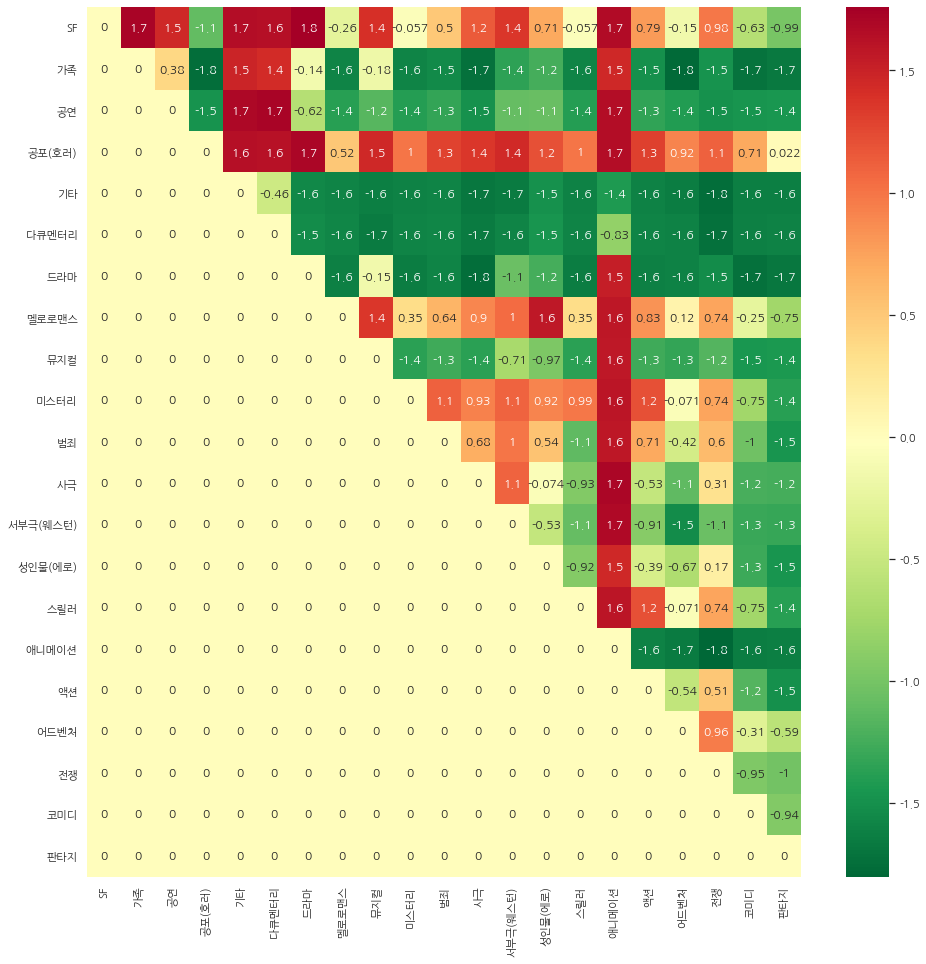

In [106]:
np.random.seed(0)

sns.set(font='NanumGothic')

plt.figure(figsize=(16,16))
plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

> 행을 기준으로 보았을 때, <code>SF</code> 와 <code>공포(호러)</code> 장르는 WEAT Secore가 0.1 이상인 데이터(빨간색-예술 영화)의 빈도수가 높음을 확인 할 수 있다.<br>
> 반면, <code>다큐멘터리</code>, <code>전쟁</code>, <code>코미디</code>, <code>판타지</code>, <code>기타</code>, <code>애니메이션</code> 장르는 WEAT Secore가 -0.1 이하인 데이터(초록색-일반 영화)의 빈도수가 높음을 확인 할 수 있다.